# Non-steady BVPs

We now briefly consider the case where we have both spatial and temporal dependence appearing in a problem, such that both initial and boundary conditions are given. The examples in this section have only a single spatial dimension, but the ideas can also be applied to problems with multiple spatial dimensions.

## 1D wave equation

In this example we will solve the following equation, subject to the given initial conditions and boundary conditions:

```{math}
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2u}{\partial x^2}, \qquad t\in[0,T], \quad x\in[0,L],
\begin{align}\end{align}
```

\begin{equation*}
u(0,x)=2 e^{-(x-L/2)^2}, \quad \frac{\partial u(0,x)}{\partial t}= 0, \quad u(t,0)=0, \quad u(t,L)=0.
\end{equation*}

This problem is hyperbolic in $(x,t)$ plane. The form of the analytic solution can be found using method of characteristics, and was shown by D'Alembert to be a travelling wave.

To find a numeric solution, we will define the following solution grid
\begin{align*}
t_{n}&=n\Delta_t,\quad \ & n=0,\ldots,N_{t}, \\
x_{i}&=i\Delta_x,\quad \ & i=0, \ldots,N_{x} \thinspace.
\end{align*}

Application of a central differences formulae for the derivatives then gives
\begin{equation*}\tag{tstep}
u^{n+1}_{i}=-u^{n-1}_{i}+2u^{n}_{i}+\left(c\frac{\Delta_t}{\Delta_x}\right)^{2}\left(u^{n}_{i+1}-2u^{n}_{i}+u^{n}_{i-1}\right),  \quad i=[1,\dots N_x-1 ],
\end{equation*}
where a  superscript has been used to denote the temporal discretisation and a subscript has been used to denote the temporal discretisation. This formula uses the result at two previous time steps. The given conditions for the spatial boundary can be applied by forced modification of the boundary nodes, $u^{n}_0=u^{n}_{N_x}=0$, $n\in[0,\dots N_t]$.

A visual summary is shown below

<br>

```{image} images/dalembert.png
:alt: secant
:align: center
:scale: 60%
```
<br>


The initial conditions allow a forward-stepping algorithm to be used. The starting value for $u^1_i $ is given by combining the initial condition for the derivative with the ODE formula, which gives
\begin{equation*}\tag{interior}u_{i}^{1}=u^{0}_{i}-\frac{1}{2}\left(c\frac{\Delta_t}{\Delta_x}\right)^{2}\left(u^{0}_{i+1}-2u^{0}_{i}+u^{0}_{i-1}\right)\thinspace., \quad i=[1,\dots N_x-1 ].\end{equation*}

We will solve the problem for the case where $L=4\pi$, $T=2\pi$, $c=4$, and plot $u(t,x)$.

First we discretise temporal and spatial variables. In the following code, `Dt`, `Dx` are arbitrary, but we need to keep `r=c*Dt/Dx` less than one for stability. You can try `r=1.01` to see what happens when this condition is violated.

In [1]:
import numpy as np

c = 4; L = 4*np.pi; T = 2*np.pi                # given parameters

x = np.linspace(0,L);       # discretisation of spatial dimension
Dx= x[1]-x[0];              # spatial step size

r=0.95; Dt=r*Dx/c;          # temporal step size via Courant parameter r

t = np.arange(0,T,Dt);      #discretisation of temporal dimension

Nx=np.size(x); Nt=np.size(t);


Next, we set up a grid to record $u(t_n,x_i)$, and apply the update steps. The steps may be summarised as follows:
1. Compute $u^0_{i}$ for $i\in[0,\dots N_x]$ from the given initial condition
2. Compute $u^1_{i}$ from (interior), applying BCs $u^{1}_0=u^{1}_{N_x}$
3. Compute $u^{n+1}_{i}$ from (tstep) for $n=[0,\dots N_t-1]$, applying BCs $u^{n}_0=u^{n}_{N_x}$ in each step

In [2]:
u = np.zeros((Nt,Nx));                         #solution grid
ii=np.arange(1,Nx-1);                          #interior x indices
#--------------------------------------------------------------
# FILL IN INITIAL CONDITIONS
u[0,:] = 2*np.exp(-(x-L/2)**2);                            #u(0,x)

#For a standing wave solution try instead (where k is an integer)
#k=1; u[0,:]=np.sin(2*np.pi*k*x/L);

u[1,ii] = u[0,ii]-r**2/2*(u[0,ii+1]-2*u[0,ii]+u[0,ii-1]);  #u(Dt,x)

#--------------------------------------------------------------
# APPLY UPDATE RULES
for n in range(2,Nt):
    neigh=u[n-1,ii+1]-2*u[n-1,ii]+u[n-1,ii-1]
    u[n,ii]=-u[n-2,ii]+2*u[n-1,ii]+r**2*neigh
#--------------------------------------------------------------

A contour plot of the solution shows that
* the initial disturbance propagates away from the origin in both directions
* disturbances are reflected at both boundaries and travel back along the mirror path

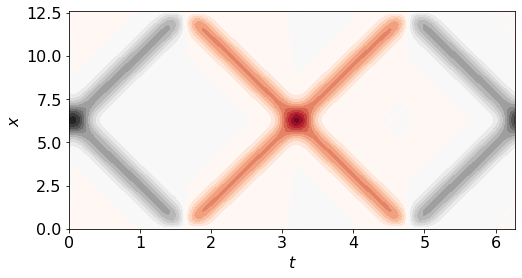

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

[X,T]=np.meshgrid(x,t)

sz=16
fig,ax = plt.subplots(figsize=(8,4))
ax.contourf(T, X, u, 20, cmap='RdGy')
ax.tick_params(labelsize=sz)
ax.set_xlabel('$t$', fontsize=sz,)
ax.set_ylabel('$x$', fontsize=sz,)

plt.show()

We can also produce a time animation of the behaviour

In [4]:
from matplotlib import animation, rc
from IPython.display import HTML

tmax=25

class testAnimation:

  def __init__(self):
    # First set up the figure, the axis, and the plot element we want to animate
    self.fig, ax = plt.subplots()
    plt.close()
    ax.set_xlim(( 0, L))
    ax.set_ylim((-2, 2))
    self.wave, = ax.plot([], [], lw=2)

  # initialization function: plot the background of each frame
  def init(self):
      return self.wave,

  # animation function. This is called sequentially  
  def animate(self, i):
      self.wave.set_data(x,u[i,:])
      return self.wave,

  def draw(self):
    global anim
    anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init,
                             frames=Nt, interval=1000*tmax/Nt, blit=True)

vis = testAnimation()
vis.draw()

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')


#anim.save('fluid.gif', writer = 'imagemagick', fps=10)

anim

## Damped 1D wave equation

As a final challenge, you may wish to have a go at solving the one-dimensional damped wave equation, which is given by

```{math}
:label: dampwavepde
\frac{\partial^2\phi}{\partial t^2}+\gamma \frac{\partial \phi}{\partial t}=c^2\frac{\partial^2\phi}{\partial x^2}.
```
By using the central difference formulas the equation of motion can be written in the following discretised form, in which $r=\frac{c\Delta t}{\Delta x}$ and $\phi_{i,j}=\phi(t_i,x_j)$.

```{math}
:label: dampwave
\left(1+\frac{\gamma}{2}\Delta t\right)\phi_{i+1,j} = 2\phi_{i,j}+r^2(\phi_{i,j-1}-2\phi_{i,j}+\phi_{i,j+1})-\phi_{i-1,j}\left(1-\frac{\gamma}{2}\Delta t\right),
```

We will take $c=0.2$, $\gamma=-0.5$, and solve the equation for $t\in[0,4]$, $x\in[0,2]$.

<br>

**Boundary conditions**

Due to the periodicity of the disturbance, the end-conditions on the spatial grid can be taken such that the solution "wraps around", i.e.
\begin{equation*}
\phi(x=-\Delta x) = \phi(x=2\pi), \quad \phi(x=2\pi +\Delta x)=\phi(x=0).
\end{equation*}
The wraparound condition could be implemented using the `numpy.roll` function.

<br>

**Intitial conditions**

We could determine the result from a pair of initial conditions of the form \begin{equation*}
\phi(0,x)=f(x),\qquad \phi_t(0,x)=g(x),
\end{equation*}
by using the central difference formula for the first derivative boundary condition, in conjunction with the update rule given by the PDE. This is the method used above for the undamped case.
The functions $f(x)$ and $g(x)$ would need to be informed by the physical problem. The solution would (likely) not be a single travelling harmonic, but would consist of a wavepacket (sum of) harmonics.

<br>

**Courant parameter**

The solution becomes more accurate as the size of the spatial and temporal steps reduces, but needs very small steps to achieve a smooth solution profile.
The stability is sensitive to the Courant parameter . For $r<1$ the solution converges, whilst for $r>1$ it does not. You can explore this behaviour by comparing the solutions for nt= 80, 81 for nx=200.

<br>

**Could we take a shortcut?**

Naively, we might choose initial conditions to match the analytic solution for the undamped case (when $\gamma=0$), in the hope that it may give a good approximation to the analytic solution for the damped case :

\begin{equation}
\phi(t=0) = \sin\left(2\pi x\right), \quad \phi(t=\Delta t) = \sin\left(2\pi (x-c\Delta t)\right).
\end{equation}

However, the result given by using this condition is unphysical. If you solve with these conditions you will find that the numeric solution rightly shows a travelling wave of decaying amplitude, but the rate of decay is staggered, which does not match reality.

In fact, hand derivations for the damped case indicate that the PDE admit particular solutions of the form
\begin{equation*}
\phi=e^{-\frac{\gamma}{2}t}\sin(kx-\omega t), \qquad \omega^2=k^2c^2 -\left(\frac{\gamma}{2}\right)^2.
\end{equation*}

If this analytic result is used to determine $\phi(\Delta t,x)$, the amplitude will be seen to decay exponentially with rate determined by the strength of the damping. This finding highlights again the importance of taking great care with the accurate implementation of any boundary conditions.